In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2)


directory_train =  '../Suhyun/ar2/seg_train/seg_train'
# train_generator = generator.flow_from_directory(
#      directory_train,
#     target_size = (224,224),
#     batch_size = 10)

directory_test = '../Suhyun/ar2/seg_test/seg_test'
train_dataset = generator.flow_from_directory(batch_size=32,
                                                 directory = directory_train,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = generator.flow_from_directory(batch_size=32,
                                                 directory = directory_train,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",

                                                 class_mode='categorical')


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


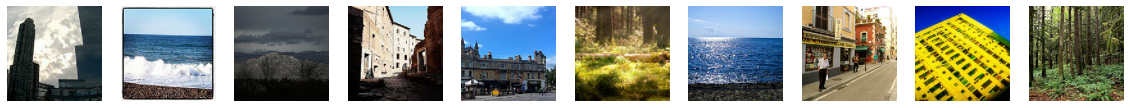

In [28]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=10,figsize=(20,20))
for i in range(10):
    ax[i].imshow(train_dataset[0][0][i])
    ax[i].axis('off')


In [30]:
def hard_swish(features):

  
  features = tf.convert_to_tensor(features)
  fdtype = features.dtype
  return features * tf.nn.relu6(features + tf.cast(3., fdtype)) * (1. / 6.)

In [31]:
def se_block(inputs, ch, ratio=16):

    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(ch//ratio, activation='relu')(x)
    y = tf.keras.layers.Dense(ch, activation='sigmoid')(x)
    y = tf.keras.layers.multiply([inputs, y])
    out = hard_swish(y)
    return out

In [32]:
def dep_bn(inputs, filter : int, kernel :int, stride: int):

  y = tf.keras.layers.Conv2D(filters = filter, kernel_size= kernel, strides= stride, padding= 'same')(inputs)
  bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
  out = tf.nn.relu6(bn)
  
  return out


def Inverted_residual_SEblock(x,  hs: bool, se: bool , filters, kernel, strides,  expansion_ratio ):


    #pointwise
    y = tf.keras.layers.Conv2D(filters = x.get_shape().as_list()[-1]*expansion_ratio, kernel_size=  1, strides = 1, padding= 'same')(x)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        y_p = hard_swish(bn)
    else:
        y_p = tf.nn.relu6(bn)
    
    
    #depthwise
    y = tf.keras.layers.DepthwiseConv2D(kernel_size=  kernel, strides= strides, padding= 'same', depth_multiplier = 1)(y_p)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        out = hard_swish(bn)
    else:
        out = tf.nn.relu6(bn)
   
    
    if se: 
        channel = out.get_shape().as_list()[-1]
        out = se_block(out, channel)

    
    #pointwise
    y = tf.keras.layers.Conv2D(filters = filters, kernel_size=  1, strides = 1, padding= 'same')(out)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        y_p = hard_swish(bn)
    else:
        y_p = tf.nn.relu6(bn)
        
        
    
    if strides == 1:
        if x.shape[3] != filters : 
           x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 1, strides = strides, padding = "same")(x)
        out  = tf.keras.layers.Add()([x, y_p])
   
    

    return y


In [33]:
def create_mobilenetV3(inputs):

   x = dep_bn(inputs, 16, 3, 2)
   x = Inverted_residual_SEblock(x, False, False, 16, 3, 1,1)

   x = Inverted_residual_SEblock(x, False, False, 24, 3, 2, 4)
   x = Inverted_residual_SEblock(x, False, False, 24, 3, 1, 3)
   
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 2, 3)
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 1, 3)
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 1, 3)

   x = Inverted_residual_SEblock(x, True, False, 80, 3, 2, 6)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 2.5)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 184/80)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 184/80)
    
   x = Inverted_residual_SEblock(x, True, True, 112, 3, 1, 6)
   x = Inverted_residual_SEblock(x, True, True, 112, 3, 1, 6)
    
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 2, 6)
   
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 1, 6)
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 1, 6)
   x = dep_bn(x, 960, 1, 1)
   
   t = tf.keras.layers.AveragePooling2D(1)(x)
   t = tf.keras.layers.Flatten()(t)
   outputs = tf.keras.layers.Dense(6, activation='softmax')(t)
   return outputs

In [34]:
# model = tf.keras.applications.MobileNetV3Large()

In [ ]:
# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    inputs = tf.keras.Input(shape=(224,224,3))
    outputs = create_mobilenetV3(inputs)

    model = tf.keras.Model(inputs, outputs)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.fit(train_dataset, validation_data=validation_dataset, epochs = 1)

In [35]:
inputs = tf.keras.Input(shape=(224,224,3))
outputs = create_mobilenetV3(inputs)

model = tf.keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [36]:
model.fit(train_dataset, validation_data=validation_dataset, epochs = 100)

Epoch 1/100
351/351 [==============================] - 38s 94ms/step - loss: 1.7331 - accuracy: 0.3561 - val_loss: 2.2056 - val_accuracy: 0.1619
Epoch 2/100
351/351 [==============================] - 32s 91ms/step - loss: 1.1805 - accuracy: 0.5304 - val_loss: 1.0823 - val_accuracy: 0.5877
Epoch 3/100
351/351 [==============================] - 32s 92ms/step - loss: 1.0227 - accuracy: 0.5874 - val_loss: 2.6593 - val_accuracy: 0.4173
Epoch 4/100
351/351 [==============================] - 32s 92ms/step - loss: 0.9168 - accuracy: 0.6313 - val_loss: 0.9247 - val_accuracy: 0.6444
Epoch 5/100
351/351 [==============================] - 32s 92ms/step - loss: 0.8341 - accuracy: 0.6777 - val_loss: 1.8406 - val_accuracy: 0.4825
Epoch 6/100
351/351 [==============================] - 32s 92ms/step - loss: 0.7716 - accuracy: 0.7104 - val_loss: 1.4387 - val_accuracy: 0.6213
Epoch 7/100
351/351 [==============================] - 32s 92ms/step - loss: 0.7352 - accuracy: 0.7208 - val_loss: 1.7858 - val_ac

In [2]:
predictions = model.predict(train_dataset[0][0])
def index_output(prediction) :
    
    index_list = []
    for pred in prediction:
        i = np.argmax(pred)
        index_list.append(i)
    return index_list

NameError: name 'model' is not defined

In [46]:
import numpy as np
y_pred = np.array(index_output(predictions))

In [47]:
y_pred.shape

(32,)

In [48]:
Y_true =[]
for y in validation_dataset[0][1]:
    Y_true.append(np.where(y==1))
Y_true = np.squeeze(np.asarray(Y_true))
Y_true.shape

(32,)

In [49]:
y_true = validation_dataset[0][1]
from sklearn.metrics import classification_report

print(classification_report(Y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       0.60      0.60      0.60         5
           3       0.33      0.67      0.44         3
           4       0.83      0.62      0.71         8
           5       1.00      0.86      0.92         7

    accuracy                           0.78        32
   macro avg       0.79      0.79      0.78        32
weighted avg       0.83      0.78      0.80        32

